In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.densenet import DenseNet201

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

Using TensorFlow backend.


# DenseNet201 Fine Tuning

In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, mean_proc='VGG16_ImageNet', test_size=0.1)

In [3]:
model_name = 'DenseNet201-Fine-Tune'

img_rows, img_cols, img_channel = 224, 224, 3
base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    verbose=2)

Epoch 1/100
 - 86s - loss: 2.2214 - acc: 0.3019 - val_loss: 1.0531 - val_acc: 0.7157

Epoch 00001: val_loss improved from inf to 1.05305, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
Epoch 2/100
 - 49s - loss: 1.1882 - acc: 0.6261 - val_loss: 0.5181 - val_acc: 0.8729

Epoch 00002: val_loss improved from 1.05305 to 0.51808, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
Epoch 3/100
 - 49s - loss: 0.7717 - acc: 0.7640 - val_loss: 0.3347 - val_acc: 0.9197

Epoch 00003: val_loss improved from 0.51808 to 0.33474, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
Epoch 4/100
 - 48s - loss: 0.5883 - acc: 0.8230 - val_loss: 0.2546 - val_acc: 0.9498

Epoch 00004: val_loss improved from 0.33474 to 0.25462, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
Epoch 5/100
 - 47s - loss: 0.4660 - acc: 0.8626 - val_loss: 0.2152 - val_acc: 0.9398

Epoch 00005: val_loss improved from 0.25462 to 0.21517, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
Epoch 6/100
 -

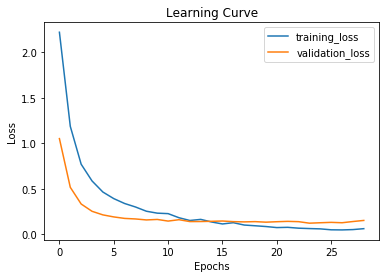

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

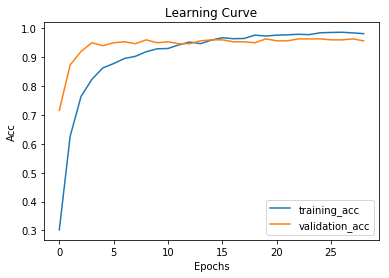

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [7]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 8s 25ms/step
Validation loss: 0.12403131839912697
Validation accuracy: 0.9632107023411371
